## Image Preprocessing
Progam of helper functions for image preprocessing.

In [1]:
# Import libraries
import os
import shutil
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Subset

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

In [2]:
# Enable GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device type: {device}')

Device type: cpu


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
# Set random seed
seed = 777
torch.manual_seed(seed)

In [7]:
# Get image class/subdirectory names
datadir = '/drive/My Drive/Colab Notebooks/Datasets/Kaggle/flowers/'
topPath = '/drive/My Drive/Colab Notebooks/Datasets/Kaggle/'
dirnames = []
for dir_path, dir_names, file_names in os.walk(datadir):
  for dir in dir_names:
    dirnames.append(dir)
print(dirnames)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [8]:
# Function to count the number of files in each directory
def dir_counts(datadir, dirnames):
  counts = []
  for i in range(len(dirnames)):
    dirpath = datadir + str(dirnames[i]) + '/'
    quant = len([name for name in os.listdir(dirpath)])
    counts.append(quant)

  # dataframe of categories
  df = pd.DataFrame({'classes': dirnames,'counts': counts}).sort_values('classes')
  
  return df, counts

In [9]:
# Initial file counts per class
df, counts = dir_counts(datadir, dirnames)
print(df)

     classes  counts
0      daisy     769
1  dandelion    1055
2       rose     784
3  sunflower     734
4      tulip     984


Text(0.5, 1.0, 'Images by Class')

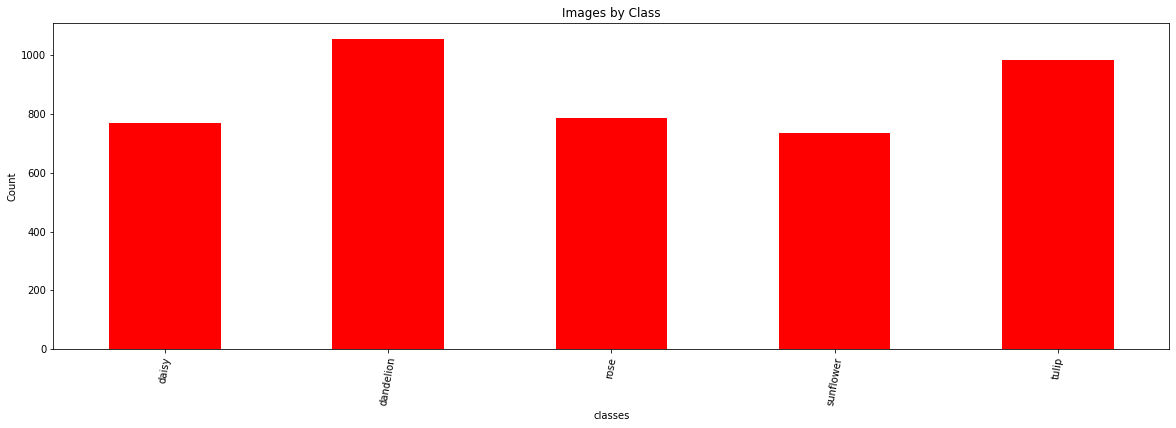

In [10]:
# Review the intial class distribution
df.set_index('classes')['counts'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Images by Class')

In [13]:
# Create a 'for' loop to level out the number of images per class
level = 600
for i in range(len(dirnames)):
  dirpath = datadir + str(dirnames[i]) + '/'
  if counts[i] < level:
    for j in range(level - counts[i]):
      f = random.choice(os.listdir(dirpath))
      f2 = str(f.split('.')[0]) + '_' + str(j) + '.jpg'
      temp = os.path.join(dirpath, f)
      temp2 = os.path.join(dirpath, f2)
      shutil.copy2(temp, temp2)
  if counts[i] > level:
    for j in range(counts[i] - level):
      f = random.choice(os.listdir(dirpath))
      temp = os.path.join(dirpath, f)
      os.remove(temp)

In [14]:
# Review the updated file counts per class
updated_df, _ = dir_counts(datadir, dirnames)
print(f'Updated file counts per class {updated_df}')

Updated file counts per class      classes  counts
0      daisy     600
1  dandelion     600
2       rose     600
3  sunflower     600
4      tulip     600


Text(0.5, 1.0, 'Images by Class')

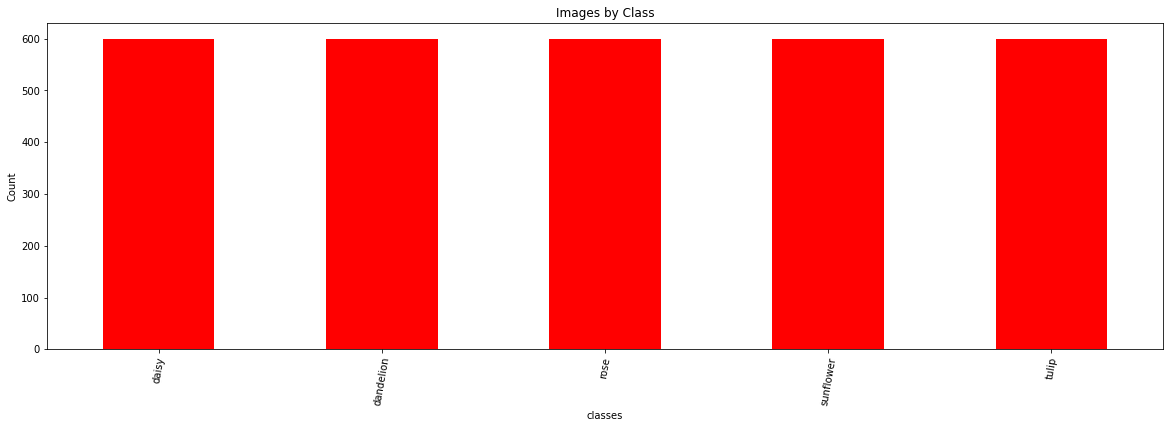

In [15]:
# Review the updated class distribution
updated_df.set_index('classes')['counts'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Images by Class')

In [12]:
# Load the dataset - transform it into appropriate sized images and convert them to a PyTorch tensor
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
raw_data = datasets.ImageFolder(root=datadir, transform=transform)
print(f'Dataset classes: {raw_data.classes}')

Dataset classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [13]:
# Review image data
x, y = raw_data[1250]
print(y)
print(x)

2
tensor([[[0.7608, 0.7725, 0.7765,  ..., 0.9255, 0.9020, 0.8824],
         [0.7961, 0.7961, 0.8039,  ..., 0.9373, 0.9216, 0.9020],
         [0.8039, 0.8157, 0.8157,  ..., 0.9451, 0.9294, 0.9137],
         ...,
         [0.6980, 0.6902, 0.6980,  ..., 0.2588, 0.1176, 0.1294],
         [0.6902, 0.6980, 0.6980,  ..., 0.1451, 0.2314, 0.4510],
         [0.6980, 0.7020, 0.7020,  ..., 0.2863, 0.4902, 0.5490]],

        [[0.0392, 0.0392, 0.0431,  ..., 0.0549, 0.0471, 0.0392],
         [0.0392, 0.0392, 0.0431,  ..., 0.0549, 0.0510, 0.0431],
         [0.0431, 0.0431, 0.0431,  ..., 0.0510, 0.0510, 0.0431],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.0039, 0.0118, 0.0118],
         [0.0431, 0.0392, 0.0392,  ..., 0.0078, 0.0039, 0.0039],
         [0.0392, 0.0353, 0.0353,  ..., 0.0078, 0.0314, 0.0157]],

        [[0.0078, 0.0118, 0.0078,  ..., 0.0353, 0.0392, 0.0275],
         [0.0118, 0.0039, 0.0078,  ..., 0.0392, 0.0471, 0.0353],
         [0.0078, 0.0118, 0.0078,  ..., 0.0392, 0.0431, 

In [ ]:
# Calculate the mean and standard deviation per color channel for normalizing the images
def norm_images(data, batch_size):
  loader = DataLoader(data, batch_size=batch_size, num_workers=1)
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.mean(2).sum(0) 
      std += batch.std(2).sum(0)

  
  mean /= nimages
  std /= nimages

  return mean, std

In [ ]:
# Image mean and standard deviation per channel for image normalization
mean, std = norm_images(raw_data, 200 )
print(f'The image mean across the color channels: {mean}')
print(f'The image standard deviation across the color channels: {std}')

The image mean across the color channels: tensor([0.4581, 0.4035, 0.2814])
The image standard deviation across the color channels: tensor([0.2648, 0.2382, 0.2302])


In [14]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [17]:
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
raw_data = datasets.ImageFolder(root=datadir, transform=transform)
print(len(raw_data))
datasets = train_val_dataset(raw_data)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}

2999
2249
750
Dataset ImageFolder
    Number of datapoints: 2999
    Root location: /drive/My Drive/Colab Notebooks/Datasets/Kaggle/flowers/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
           )


In [26]:
len(datasets['train'].dataset)

2999

In [16]:
import shutil
import os

def split_dataset_into_3(path_to_dataset, train_ratio, valid_ratio, topDir):
    """
    split the dataset in the given path into three subsets(test,val,train)
    :param path_to_dataset:
    :param train_ratio:
    :param valid_ratio:
    :return:
    """
    _, sub_dirs, _ = next(iter(os.walk(path_to_dataset)))  # retrieve name of subdirectories
    sub_dir_item_cnt = [0 for i in range(len(sub_dirs))]  # list for counting items in each sub directory(class)

    # directories where the splitted dataset will lie
    dir_train = os.path.join(os.path.dirname(topDir), 'flowers_split/train')
    dir_valid = os.path.join(os.path.dirname(topDir), 'flowers_split/valid')
    dir_test = os.path.join(os.path.dirname(topDir), 'flowers_split/test')

    for i, sub_dir in enumerate(sub_dirs):

        print(sub_dir)

        dir_train_dst = os.path.join(dir_train, sub_dir)  # directory for destination of train dataset
        dir_valid_dst = os.path.join(dir_valid, sub_dir)  # directory for destination of validation dataset
        dir_test_dst = os.path.join(dir_test, sub_dir)  # directory for destination of test dataset

        # variables to save the sub directory name(class name) and to count the images of each sub directory(class)
        class_name = sub_dir
        sub_dir = os.path.join(path_to_dataset, sub_dir)
        sub_dir_item_cnt[i] = len(os.listdir(sub_dir))

        items = os.listdir(sub_dir)

        # transfer data to trainset
        for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio)):
            if not os.path.exists(dir_train_dst):
                os.makedirs(dir_train_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_train_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)

        # transfer data to validation
        for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio) + 1,
                              round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio))):
            if not os.path.exists(dir_valid_dst):
                os.makedirs(dir_valid_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_valid_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)

        # transfer data to testset
        for item_idx in range(round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio)) + 1, sub_dir_item_cnt[i]):
            if not os.path.exists(dir_test_dst):
                os.makedirs(dir_test_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_test_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)

    return

In [18]:
split_dataset_into_3(datadir, 0.7, 0.1, topPath)

daisy
dandelion
rose
sunflower
tulip
